
<center>
<h1>NFL Data Analysis</h1>
<h3>This is part 1 in a 2 Notebook excercise in leveraging Spark to perform simple Data Engineering and Analysis using NFL Data provided by "Burnt Sushi".</h3>

<img src="https://github.com/bradenrc/nfl_spark/raw/master/intro.png" style="width:60%;height:60%"/>

</center>

<h3>Notebook Flow</h3>
<a href="https://github.com/bradenrc/nfl_spark/raw/master/NFL%20Demo%20Flow%20-%20New%20Page.png">
<img src="https://github.com/bradenrc/nfl_spark/raw/master/NFL%20Demo%20Flow%20-%20New%20Page.png" style="width:30%;height:30%" />
</a>

<h3>Download JDBC Driver for Postgres</h3>
<br>
Download the JDBC driver, your default working directory is in the classpath, so it will be accessible to Spark.

In [1]:
!wget https://jdbc.postgresql.org/download/postgresql-9.4.1207.jre7.jar -nc

File ‘postgresql-9.4.1207.jre7.jar’ already there; not retrieving.



If you know the connection infromation, you can just connect.

In [2]:
game_df = sqlContext.read.format('jdbc').options(url='jdbc:postgresql://bluemix-sandbox-dal-9-portal.2.dblayer.com:15656/compose', \
                                            dbtable='game', \
                                            user='admin', \
                                            password='RFSUPYGYXCMNKGUN'
                                           ).load()

In [3]:
game_df.registerTempTable("game")

If not, you can "insert" the credentials via the data menu.

In [4]:
credentials_1 = {
  'host':'bluemix-sandbox-dal-9-portal.2.dblayer.com',
  'port':'15656',
  'user':'admin',
  'password':"""RFSUPYGYXCMNKGUN""",
  'database':'compose',
  'table':'player'
}

Here we use the dictionary inserted and create a connection string.

In [5]:
query = """
CREATE TEMPORARY TABLE player
USING org.apache.spark.sql.jdbc
OPTIONS (
   url 'jdbc:postgresql://{host}:{port}/{database}', 
  dbtable '{table}', 
  user '{user}', 
  password '{password}'
)
""".format(**credentials_1)
player = sqlContext.sql(query)

Take a simple count of the games we have available from the database

In [6]:
game_df.count()

2638

In [7]:

team = sqlContext.read.format('jdbc').options(url='jdbc:postgresql://bluemix-sandbox-dal-9-portal.2.dblayer.com:15656/compose', \
                                            dbtable='team', \
                                            user='admin', \
                                            password='RFSUPYGYXCMNKGUN'
                                           ).load()


team.toPandas().to_csv('team.csv')

<h3>Explore the data</h3>
Here we are going to create some simple charts to make sure that the data looks normal.<br>
<br>
Below you can see a full relationship diagram of the tables and descriptions:

<ul>
<li>
<strong>meta</strong> stores information about the database or about the state of the 
world. For example, it keeps track of the version of the database and the
current week of the current NFL season.</li>
<li>
<strong>team</strong> stores a row for each team in the league. There is also a row that 
corresponds to an unknown team called <code>UNK</code>. This is used for players that 
are not on any current roster.</li>
<li>
<strong>player</strong> stores ephemeral data about players. Namely, it is the most 
current information about each player known by nfldb. The data is nearly a 
total copy of the data in nflgame's JSON player database.</li>
<li>
<strong>game</strong> stores a row for each NFL game in the preseason, regular season and 
postseason dating back to 2009. This includes games that are scheduled in the 
future but have not been played.</li>
<li>
<strong>drive</strong> stores a row for each drive in a single game.</li>
<li>
<strong>play</strong> stores a row for each play in a single drive.</li>
<li>
<strong>agg_play</strong> stores a row for each play aggregating statistics from the
corresponding rows in the <code>play_player</code> table.</li>
<li>
<strong>play_player</strong> stores a row for each player statistic in a single play.</li>
</ul>

<img src="https://camo.githubusercontent.com/c62404262a380b061c6f4e3e5a38677269be4739/687474703a2f2f6275726e7473757368692e6e65742f73747566662f6e666c64622f6e666c64622d636f6e64656e7365642e706e67" style="width:60%;height:60%"/>

<h3>We can use Pandas and Matplotlib to Chart the data</h3>
<img align="left" src="http://pandas.pydata.org/_static/pandas_logo.png" />

In [8]:
query = """
select
 COLLEGE,
 count(*) as COUNT
from
 player
where
 COLLEGE is not null
group by
 COLLEGE
order by count(*) desc
limit 20
"""
player_pd = sqlContext.sql(query).toPandas()

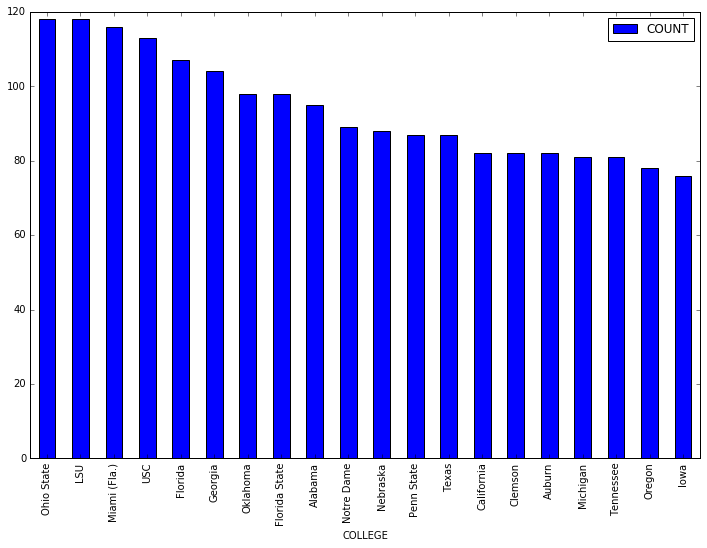

In [9]:
%matplotlib inline 
import matplotlib.pyplot as plt, numpy as np

player_pd.plot(kind='bar', x='COLLEGE', figsize=(12, 8))

<h4>If we don't know the Schema, simply print it out</h4>

In [10]:
game_df.printSchema()

root
 |-- gsis_id: string (nullable = false)
 |-- gamekey: string (nullable = true)
 |-- start_time: timestamp (nullable = false)
 |-- week: integer (nullable = false)
 |-- day_of_week: string (nullable = false)
 |-- season_year: integer (nullable = false)
 |-- season_type: string (nullable = false)
 |-- finished: boolean (nullable = false)
 |-- home_team: string (nullable = false)
 |-- home_score: integer (nullable = false)
 |-- home_score_q1: integer (nullable = true)
 |-- home_score_q2: integer (nullable = true)
 |-- home_score_q3: integer (nullable = true)
 |-- home_score_q4: integer (nullable = true)
 |-- home_score_q5: integer (nullable = true)
 |-- home_turnovers: integer (nullable = false)
 |-- away_team: string (nullable = false)
 |-- away_score: integer (nullable = false)
 |-- away_score_q1: integer (nullable = true)
 |-- away_score_q2: integer (nullable = true)
 |-- away_score_q3: integer (nullable = true)
 |-- away_score_q4: integer (nullable = true)
 |-- away_score_q5: int

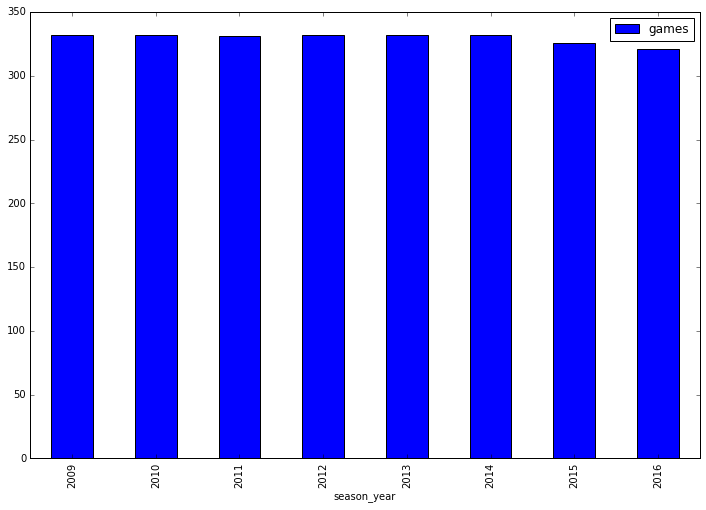

In [12]:
query = """select 
                count(*) as games,
                season_year 
            from game
            group by season_year
            order by season_year"""

sqlContext.sql(query).toPandas().plot(kind='bar', y='games', x="season_year", figsize=(12, 8))

<h3>Normalize the Data</h3>

We have one row for each game, we can pivot the data and make it so that we have one row for each team\game.


In [13]:
query = """

SELECT GSIS_ID
       , GAMEKEY
       , START_TIME
       , WEEK
       , DAY_OF_WEEK
       , SEASON_YEAR
       , SEASON_TYPE
       , FINISHED
	   , HOME_TEAM as LOCATION
	   , 1 as HOME_GAME
       , HOME_TEAM as TEAM
       , HOME_SCORE as SCORE
       , HOME_SCORE_Q1 as SCORE_Q1
       , HOME_SCORE_Q2 as SCORE_Q2
       , HOME_SCORE_Q3 as SCORE_Q3
       , HOME_SCORE_Q4 as SCORE_Q4
       , HOME_SCORE_Q5 as SCORE_Q5
       , HOME_TURNOVERS as TURNOVERS
	   , AWAY_TEAM as OPPONENT_TEAM
       , AWAY_SCORE as OPPONENT_SCORE
       , AWAY_SCORE_Q1 as OPPONENT_SCORE_Q1
       , AWAY_SCORE_Q2 as OPPONENT_SCORE_Q2
       , AWAY_SCORE_Q3 as OPPONENT_SCORE_Q3
       , AWAY_SCORE_Q4 as OPPONENT_SCORE_Q4
       , AWAY_SCORE_Q5 as OPPONENT_SCORE_Q5
       , AWAY_TURNOVERS as OPPONENT_TURNOVERS
	   ,CASE 
	   		WHEN HOME_SCORE > AWAY_SCORE then 1
			WHEN HOME_SCORE < AWAY_SCORE then 0
		END as  WON
		,CASE 
	   		WHEN HOME_SCORE = AWAY_SCORE then 1
			WHEN HOME_SCORE != AWAY_SCORE then 0
		END as  TIE
  FROM game
  UNION ALL
  SELECT GSIS_ID
       , GAMEKEY
       , START_TIME
       , WEEK
       , DAY_OF_WEEK
       , SEASON_YEAR
       , SEASON_TYPE
       , FINISHED
       , HOME_TEAM as LOCATION
	   , 0 as HOME_GAME
       , AWAY_TEAM as TEAM
       , AWAY_SCORE as SCORE
       , AWAY_SCORE_Q1 as SCORE_Q1
       , AWAY_SCORE_Q2 as SCORE_Q2
       , AWAY_SCORE_Q3 as SCORE_Q3
       , AWAY_SCORE_Q4 as SCORE_Q4
       , AWAY_SCORE_Q5 as SCORE_Q5
       , AWAY_TURNOVERS as TURNOVERS
	   , HOME_TEAM as OPPONENT_TEAM
       , HOME_SCORE as OPPONENT_SCORE
       , HOME_SCORE_Q1 as OPPONENT_SCORE_Q1
       , HOME_SCORE_Q2 as OPPONENT_SCORE_Q2
       , HOME_SCORE_Q3 as OPPONENT_SCORE_Q3
       , HOME_SCORE_Q4 as OPPONENT_SCORE_Q4
       , HOME_SCORE_Q5 as OPPONENT_SCORE_Q5
       , HOME_TURNOVERS as OPPONENT_TURNOVERS
	   ,CASE 
	   		WHEN AWAY_SCORE > HOME_SCORE then 1
			WHEN AWAY_SCORE < HOME_SCORE then 0
		END as  WON
		,CASE 
	   		WHEN HOME_SCORE = AWAY_SCORE then 1
			WHEN HOME_SCORE != AWAY_SCORE then 0
		END as  TIE
  FROM game
"""

In [14]:
games_norm_df = sqlContext.sql(query)
games_norm_df.registerTempTable("game_normalized")

In [ ]:
games_norm_df.toPandas().to_csv('games_norm_df.csv', append = False)

<h3>Some simple exploration of the data </h3>

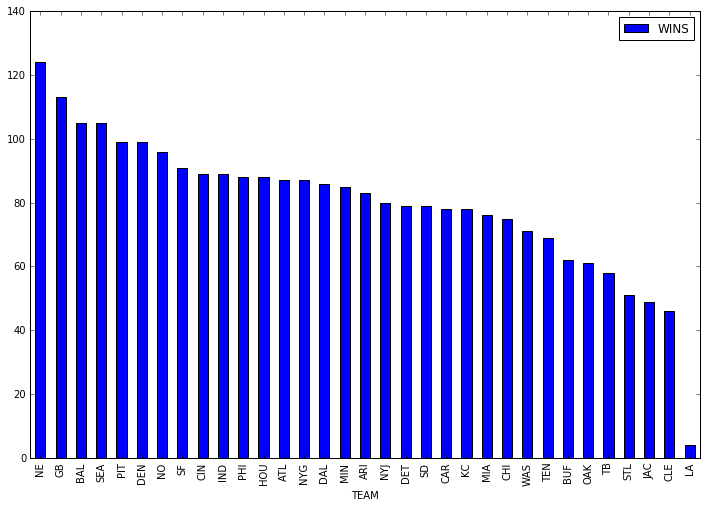

In [15]:
query = """
select
    sum(WON) as WINS,
    TEAM
FROM
    game_normalized
WHERE TEAM != 'UNK'
GROUP BY
    TEAM
ORDER BY WINS desc
"""
pd = sqlContext.sql(query).toPandas()
pd.plot(kind='bar', x='TEAM', figsize=(12, 8))

<h3>Pull in team Metadata</h3>
<br>
To get the weather data, we need the latitude and longitude of each of the stadiums.
<br>
The first step is to get the team name to lookup in Wikipedia

In [16]:
team_df = sqlContext.read.format('jdbc').options(url='jdbc:postgresql://bluemix-sandbox-dal-9-portal.2.dblayer.com:15656/compose', \
                                            dbtable='team', \
                                            user='admin', \
                                            password='RFSUPYGYXCMNKGUN'
                                           ).load()
team_df.registerTempTable("team")

In [17]:
team_df.show()

+-------+------------+---------+
|team_id|        city|     name|
+-------+------------+---------+
|    ARI|     Arizona|Cardinals|
|    ATL|     Atlanta|  Falcons|
|    BAL|   Baltimore|   Ravens|
|    BUF|     Buffalo|    Bills|
|    CAR|    Carolina| Panthers|
|    CHI|     Chicago|    Bears|
|    CIN|  Cincinnati|  Bengals|
|    CLE|   Cleveland|   Browns|
|    DAL|      Dallas|  Cowboys|
|    DEN|      Denver|  Broncos|
|    DET|     Detroit|    Lions|
|     GB|   Green Bay|  Packers|
|    HOU|     Houston|   Texans|
|    IND|Indianapolis|    Colts|
|    JAC|Jacksonville|  Jaguars|
|     KC| Kansas City|   Chiefs|
|    MIA|       Miami| Dolphins|
|    MIN|   Minnesota|  Vikings|
|     NE| New England| Patriots|
|     NO| New Orleans|   Saints|
+-------+------------+---------+
only showing top 20 rows



<h3>Scrape Wikipedia and get the Stadium Metadata for each Team </h3>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/US_National_Football_League_Teams_Location-en.svg/1000px-US_National_Football_League_Teams_Location-en.svg.png" style="width:30%;height:30%" align="left" /> 
<br>
<br>
<img src="https://github.com/bradenrc/nfl_spark/raw/master/wikipedia_nfl.png" style="width:70%;height:70%" align="left" />

In [18]:
import urllib
from bs4 import BeautifulSoup
import re


url = "https://en.wikipedia.org/wiki/National_Football_League"

html = urllib.urlopen(url)
bsObj = BeautifulSoup(html, "html.parser")

table = bsObj.find("table", {"class": "navbox plainrowheaders wikitable"})
rows = table.findAll("tr")


def clean_string(cstring):

    st = cstring.replace("*", "")
    st = re.sub(r'[^\x00-\x7F]+',' ', st)
    st = st.replace("\n", " ")

    if st.__contains__("["):
        return st[0:st.index("[")].strip()
    else:
        return st.strip()


stadiums_l = []

for row in rows:
    r = []
    for cell in row.findAll(['td', 'th']):
        r.append(cell.get_text())
        if len(r) == 7 and r[0] not in ["North", "South", "East", "West", "Division[53]"]:
            team = clean_string(r[0])
            location = clean_string(r[1])
            stadium = clean_string(r[2])
            lat = r[4].split(" ")[6].replace(";", "")
            long = r[4].split(" ")[7][0:7]

            stadiums_l.append([team, location, stadium, lat, long])

        if len(r) == 8 and r[1] not in ["Club[53]"]:
            team = clean_string(r[1])
            location = r[2]
            stadium = r[3]
            lat = r[5].split(" ")[6].replace(";", "")
            long = r[5].split(" ")[7][0:7]
            stadiums_l.append([team, location, stadium, lat, long])

print stadiums_l[0]
print stadiums_l[1]

[u'Buffalo Bills', u'Orchard Park, NY', u'New Era Field', u'42.774', u'-78.787']
[u'Miami Dolphins', u'Miami Gardens, FL', u'Hard Rock Stadium', u'25.958', u'-80.239']


<h4>Pull from another Wikipedia page to get the roof type</h4>

In [19]:
url = "https://en.wikipedia.org/wiki/List_of_current_National_Football_League_stadiums"

html = urllib.urlopen(url)
bsObj = BeautifulSoup(html, "html.parser")

table = bsObj.find("table", {"class": "wikitable sortable plainrowheaders"})
rows = table.findAll("tr")

stadiums_l_dome = []

for row in rows:
    r = []
    for cell in row.findAll(['td', 'th']):
        r.append(cell.get_text())
        if len(r) == 7 and r[0] not in ["Image"]:
            stadium = clean_string(r[1])
            size = clean_string(r[2])
            location = clean_string(r[3])
            surface = clean_string(r[4])
            roof_type = clean_string(r[5])
            teams = clean_string(r[6])
            stadiums_l_dome.append([stadium, size, location, surface, roof_type, teams])
            
print stadiums_l_dome[0]
print stadiums_l_dome[1]

[u'Arrowhead Stadium', u'76,416', u'Kansas City, Missouri', u'Latitude 36 Bermuda Grass', u'Open', u'Kansas City Chiefs']
[u'AT&T Stadium', u'80,000', u'Arlington, Texas', u'Matrix RealGrass artificial turf', u'Retractable', u'Dallas Cowboys']


In [20]:
all_stadium_data = []

for s1 in stadiums_l_dome:
    #print stadium[0]
    for s2 in stadiums_l:
        if s1[0] == s2[2]:
            all_stadium_data.append(s1 + s2)

for s in all_stadium_data[:10]:
     print  [s[6], s[2], s[0], s[9],s[10], s[3], s[4]]
    

[u'Kansas City Chiefs', u'Kansas City, Missouri', u'Arrowhead Stadium', u'39.049', u'-94.484', u'Latitude 36 Bermuda Grass', u'Open']
[u'Dallas Cowboys', u'Arlington, Texas', u'AT&T Stadium', u'32.748', u'-97.093', u'Matrix RealGrass artificial turf', u'Retractable']
[u'Carolina Panthers', u'Charlotte, North Carolina', u'Bank of America Stadium', u'35.226', u'-80.853', u'Voyager Bermuda Grass', u'Open']
[u'Seattle Seahawks', u'Seattle, Washington', u'CenturyLink Field', u'47.595', u'-122.33', u'FieldTurf Revolution', u'Open']
[u'Jacksonville Jaguars', u'Jacksonville, Florida', u'EverBank Field', u'30.324', u'-81.638', u'Tifway 419 Bermuda Grass', u'Open']
[u'Washington Redskins', u'Landover, Maryland', u'FedExField', u'38.908', u'-76.864', u'Latitude 36 Bermuda Grass', u'Open']
[u'Cleveland Browns', u'Cleveland, Ohio', u'FirstEnergy Stadium', u'41.506', u'-81.699', u'Kentucky Bluegrass', u'Open']
[u'Detroit Lions', u'Detroit, Michigan', u'Ford Field', u'42.34', u'-83.046', u'FieldTurf 

<h4>Create a Spark table "stadiums" with the Wikipedia data</h4>

In [21]:
from pyspark.sql import Row

stadiums_rdd = sc.parallelize(all_stadium_data)
stadiums_df = stadiums_rdd.map(lambda x: Row(team=x[6], stadium_city=x[2], stadium_name=x[0], latitude=x[9], longitude=x[10], fieldtype=x[3], roof=x[4])).toDF()
stadiums_df.registerTempTable("stadiums")

for s in stadiums_df.take(2):
    print s

Row(fieldtype=u'Latitude 36 Bermuda Grass', latitude=u'39.049', longitude=u'-94.484', roof=u'Open', stadium_city=u'Kansas City, Missouri', stadium_name=u'Arrowhead Stadium', team=u'Kansas City Chiefs')
Row(fieldtype=u'Matrix RealGrass artificial turf', latitude=u'32.748', longitude=u'-97.093', roof=u'Retractable', stadium_city=u'Arlington, Texas', stadium_name=u'AT&T Stadium', team=u'Dallas Cowboys')


In [22]:
sqlContext.sql("select * from stadiums").toPandas()

,fieldtype,latitude,longitude,roof,stadium_city,stadium_name,team
0,Latitude 36 Bermuda Grass,39.049,-94.484,Open,"Kansas City, Missouri",Arrowhead Stadium,Kansas City Chiefs
1,Matrix RealGrass artificial turf,32.748,-97.093,Retractable,"Arlington, Texas",AT&T Stadium,Dallas Cowboys
2,Voyager Bermuda Grass,35.226,-80.853,Open,"Charlotte, North Carolina",Bank of America Stadium,Carolina Panthers
3,FieldTurf Revolution,47.595,-122.33,Open,"Seattle, Washington",CenturyLink Field,Seattle Seahawks
4,Tifway 419 Bermuda Grass,30.324,-81.638,Open,"Jacksonville, Florida",EverBank Field,Jacksonville Jaguars
5,Latitude 36 Bermuda Grass,38.908,-76.864,Open,"Landover, Maryland",FedExField,Washington Redskins
6,Kentucky Bluegrass,41.506,-81.699,Open,"Cleveland, Ohio",FirstEnergy Stadium,Cleveland Browns
7,FieldTurf Classic HD,42.34,-83.046,Fixed,"Detroit, Michigan",Ford Field,Detroit Lions
8,FieldTurf Classic HD,33.758,-84.401,Fixed,"Atlanta, Georgia",Georgia Dome,Atlanta Falcons
9,FieldTurf Revolution,42.091,-71.264,Open,"Foxborough, Massachusetts",Gillette Stadium,New England Patriots


<h3>Create a simple function to find the team name in the team column</h3>

Wikipedia has "City Team" and our database has just the "Team", knowing that each team name is unique <br>
we can look for the "team" in the "city team" to match the two metadata tables.<br>

This will give us the TEAM_ID to match each game and the latitude\longitude to lookup the weather.

In [23]:
def get_last_string(s):
    st = s.strip()
    return st.split(" ")[-1]

sqlContext.registerFunction("get_last_string", get_last_string)

In [25]:
query = """
select
    TEAM_ID,
    CITY,
    NAME,
    stadium_city,
    stadium_name,
    team,
    latitude,
    longitude,
    roof,
    fieldtype
from
    stadiums, team
where 
    get_last_string(team) = NAME
"""

team_locations = sqlContext.sql(query)
team_locations.registerTempTable("team_locations")
team_locations.toPandas()

,TEAM_ID,CITY,NAME,stadium_city,stadium_name,team,latitude,longitude,roof,fieldtype
0,HOU,Houston,Texans,"Houston, Texas",NRG Stadium,Houston Texans,29.685,-95.411,Retractable,UBU Sports Speed Series S5-M Synthetic Turf
1,NE,New England,Patriots,"Foxborough, Massachusetts",Gillette Stadium,New England Patriots,42.091,-71.264,Open,FieldTurf Revolution
2,OAK,Oakland,Raiders,"Oakland, California",Oakland Alameda County Coliseum,Oakland Raiders,37.752,-122.20,Open,Tifway II Bermuda Grass
3,WAS,Washington,Redskins,"Landover, Maryland",FedExField,Washington Redskins,38.908,-76.864,Open,Latitude 36 Bermuda Grass
4,ARI,Arizona,Cardinals,"Glendale, Arizona",University of Phoenix Stadium,Arizona Cardinals,33.528,-112.26,Retractable,Tifway 419 Bermuda Grass
5,IND,Indianapolis,Colts,"Indianapolis, Indiana",Lucas Oil Stadium,Indianapolis Colts,39.760,-86.164,Retractable,FieldTurf Classic HD
6,NO,New Orleans,Saints,"New Orleans, Louisiana",Mercedes-Benz Superdome,New Orleans Saints,29.951,-90.081,Fixed,UBU Sports Speed Series S5-M Synthetic Turf
7,ATL,Atlanta,Falcons,"Atlanta, Georgia",Georgia Dome,Atlanta Falcons,33.758,-84.401,Fixed,FieldTurf Classic HD
8,SD,San Diego,Chargers,"Carson, California",StubHub Center,Los Angeles Chargers,33.86444,-118.26,Open,Grass
9,KC,Kansas City,Chiefs,"Kansas City, Missouri",Arrowhead Stadium,Kansas City Chiefs,39.049,-94.484,Open,Latitude 36 Bermuda Grass


<h3>Pull out each distinct game</h3>

In [32]:
query = """
select
    DISTINCT
    GSIS_ID,
    START_TIME,
    team_locations.stadium_city as stadium_city,
    latitude,
    longitude,
    roof,
    game_normalized.LOCATION
from
    game_normalized 
inner join team_locations on
     game_normalized.LOCATION = team_locations.TEAM_ID
where lower(roof) = 'open'
limit 10
"""
sqlContext.sql(query).toPandas()

,GSIS_ID,START_TIME,stadium_city,latitude,longitude,roof,LOCATION
0,2014120100,2014-12-01 19:30:00,"East Rutherford, New Jersey",40.814,-74.074,Open,NYJ
1,2014122105,2014-12-21 12:00:00,"East Rutherford, New Jersey",40.814,-74.074,Open,NYJ
2,2015082151,2015-08-21 18:30:00,"East Rutherford, New Jersey",40.814,-74.074,Open,NYJ
3,2015121301,2015-12-13 12:00:00,"East Rutherford, New Jersey",40.814,-74.074,Open,NYJ
4,2009092005,2009-09-20 12:00:00,"East Rutherford, New Jersey",40.814,-74.074,Open,NYJ
5,2015111200,2015-11-12 19:25:00,"East Rutherford, New Jersey",40.814,-74.074,Open,NYJ
6,2015110805,2015-11-08 12:00:00,"East Rutherford, New Jersey",40.814,-74.074,Open,NYJ
7,2015101801,2015-10-18 12:00:00,"East Rutherford, New Jersey",40.814,-74.074,Open,NYJ
8,2015122702,2015-12-27 12:00:00,"East Rutherford, New Jersey",40.814,-74.074,Open,NYJ
9,2009111503,2009-11-15 12:00:00,"East Rutherford, New Jersey",40.814,-74.074,Open,NYJ


In [33]:
query = """
select
    DISTINCT
    GSIS_ID,
    START_TIME,
    team_locations.stadium_city as stadium_city,
    latitude,
    longitude 
    --,game_normalized.LOCATION
from
    game_normalized 
inner join team_locations on
     game_normalized.LOCATION = team_locations.TEAM_ID
where lower(roof) = 'open'
"""
distinct_games_df = sqlContext.sql(query)
distinct_games_df.registerTempTable("distinct_games")
print distinct_games_df.count()

1972


<h3>Get the Weather Data</h3>

1. Create a function to parse the game id and get a "padded" data for example 20160101 *note the leading 0s<br>
2. Create a function to get the Weather data, this takes padded date, latitude, longitude


In [35]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

#function to take the left 8 characters of the Game ID (represents the YEARMONTHDAY)
def parse_datekey(datestr):
    if len(str(datestr)) >= 8:
        return str(datestr)[0:8]
    else:
        return ""

#Register the function for Spark
parse_datekey_udf = udf(parse_datekey, StringType())
                            
#create the new dataframe with the datekey column
distinct_games_df_withdate = distinct_games_df.withColumn("datekey", parse_datekey_udf(distinct_games_df["GSIS_ID"]))

distinct_games_df_withdate.registerTempTable("distinct_games_df_withdate")

#sample of first 5 rows
for x in distinct_games_df_withdate.take(5):
    print x


Row(GSIS_ID=u'2013102001', START_TIME=datetime.datetime(2013, 10, 20, 12, 0), stadium_city=u'Charlotte, North Carolina', latitude=u'35.226', longitude=u'-80.853', datekey=u'20131020')
Row(GSIS_ID=u'2011112402', START_TIME=datetime.datetime(2011, 11, 24, 19, 20), stadium_city=u'Baltimore, Maryland', latitude=u'39.278', longitude=u'-76.623', datekey=u'20111124')
Row(GSIS_ID=u'2009101108', START_TIME=datetime.datetime(2009, 10, 11, 15, 5), stadium_city=u'Santa Clara, California', latitude=u'37.403', longitude=u'-121.97', datekey=u'20091011')
Row(GSIS_ID=u'2013020300', START_TIME=datetime.datetime(2013, 2, 3, 17, 30), stadium_city=u'Santa Clara, California', latitude=u'37.403', longitude=u'-121.97', datekey=u'20130203')
Row(GSIS_ID=u'2012081854', START_TIME=datetime.datetime(2012, 8, 18, 19, 0), stadium_city=u'Los Angeles, California', latitude=u'34.014', longitude=u'-118.28', datekey=u'20120818')


In [36]:
wapi_key = "c8cdc94974038e0a814d9176d749a730"

In [ ]:
import datetime, time, json, requests

def get_weather(date_str, lat, long):
    #Build the URI to get the JSON blob
    uri = "https://api.weather.com/v1/geocode/{lat}/{long}/observations/historical.json?units=e&startDate={date}&endDate={date}&apiKey={key}".format( \
        lat=lat, long=long, date=date_str, key=wapi_key)

    #get JSON blob and create JSON object
    r = requests.get(uri)
    weather_json = json.loads(r.text)
    r_dict = {}
    
    return weather_json

sqlContext.registerFunction("get_weather", get_weather)

In [ ]:
#distinct_games_weather_df = distinct_games_df_withdate.filter(distinct_games_df_withdate.datekey == 20141221).map(lambda x: Row(**dict(x.asDict(), weather=get_weather(x.datekey, x.latitude, x.longitude)))).toDF()
distinct_games_weather_df = distinct_games_df_withdate.rdd.map(lambda x: Row(**dict(x.asDict(), weather=get_weather(x.datekey, x.latitude, x.longitude)))).toDF()
distinct_games_weather_df.registerTempTable("distinct_games_weather")
distinct_games_weather_df.printSchema()

In [ ]:
distinct_games_weather_df.show(5)

Double check our counts, it should be the same as the original game table and the distinct game table

In [ ]:
distinct_games_weather_df.count()

<h3>Persist the data</h3>
The record set is fairly small, so in this case we will just store it in our local enviroment.<br>
First we delete anything that may exist

In [ ]:
!rm -rf ./weather_p/
!rm -rf ./games_norm_df_p/

In [ ]:
distinct_games_weather_df.write.parquet("./weather_p/")
games_norm_df.write.parquet("./games_norm_df_p/")